### scmap to compare our gonadal immune cells to myeloid cells from Bian et al., 2020

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(Matrix)
library(scmap)

#### Load data

In [7]:
path_to_bian = '/nfs/team292/vl6/Microglia/'
path_to_atlas = '/nfs/team292/vl6/immune_fetal_gonads/'

In [8]:
bian = sc.read(path_to_bian + 'Paper_microglia.h5ad')
bian = anndata.AnnData(X = bian.raw.X, var = bian.raw.var, obs = bian.obs)
bian.shape

(1231, 18917)

In [9]:
atlas = sc.read(path_to_atlas + 'immune_merged_lineages_annotated.h5ad')
atlas.shape

(19538, 20675)

In [10]:
atlas = anndata.AnnData(X = atlas.raw.X, var = atlas.raw.var, obs = atlas.obs)
atlas.shape

(19538, 28497)

#### Intersect genes

In [12]:
bian_genes = bian.var_names.to_list()
atlas_genes = atlas.var_names.to_list()

from functools import reduce
inters = reduce(np.intersect1d, (bian_genes, atlas_genes))
len(inters)

16280

In [13]:
bian = bian[:, list(inters)]
bian

/home/jovyan/my-conda-envs/scanpy_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 1231 × 16280
    obs: 'tissue', 'paper_annotation', 'stage', 'individual', 'paper_cluster', 'n_genes', 'n_counts', 'sample'
    var: 'n_cells'

In [14]:
atlas = atlas[:, list(inters)]

#### Downsample more frequent classes in our atlas for computational efficiency

In [16]:
myindex = atlas.obs['clusters'].value_counts().index 
myvalues = atlas.obs['clusters'].value_counts().values
clusters = pd.Series(myvalues, index = myindex)
clusters.values

array([7620, 2668, 1528, 1015, 1003,  743,  743,  571,  547,  519,  489,
        355,  343,  329,  274,  226,  211,  210,  144])

In [18]:
import random
from itertools import chain

# Find clusters with > n cells
n = 500
cl2downsample = clusters.index[ clusters.values > n ]

# save all barcode ids from small clusters
holder = []
holder.append( atlas.obs_names[[ i not in cl2downsample for i in atlas.obs['clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = atlas[[ i == cl for i in atlas.obs['clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
atlas = atlas[[ i in samples for i in atlas.obs_names ]]
atlas.X.shape

tissue-repair mac
mono
early T
pro-B
cDC2
NK
tissue-repair mac cycling
microglia-like mac
B cell
pre-B


(7581, 16280)

#### Convert anndata to SingleCellExperiment

In [19]:
%%R -i atlas
atlas

class: SingleCellExperiment 
dim: 16280 7581 
metadata(0):
assays(1): X
rownames(16280): A1BG A1CF ... ZYX ZZEF1
rowData names(194): gene_ids.0.0 feature_types.0.0 ...
  feature_types.52.1 n_cells.52.1
colnames(7581): FCA_GND8047884_CCCATACAGAGATGAG
  FCA_GND8047884_TGGCCAGCAGAAGCAC ... HD_F_GON9883868_TGCGTGGCACACATGT
  HD_F_GON9883868_TGTATTCAGAAACGCC
colData names(59): batch batch_collection ... main_lineages
  dpt_pseudotime
reducedDimNames(0):
altExpNames(0):


In [20]:
%%R -i bian
bian

class: SingleCellExperiment 
dim: 16280 1231 
metadata(0):
assays(1): X
rownames(16280): A1BG A1CF ... ZYX ZZEF1
rowData names(1): n_cells
colnames(1231): YS5_TKR180900693_HT3YJCCXY_L4_sc60
  YS5_TKR180900693_HT3YJCCXY_L4_sc64 ... L3_FKDL190665156.1a_sc47
  L3_FKDL190665156.1a_sc48
colData names(8): tissue paper_annotation ... n_counts sample
reducedDimNames(0):
altExpNames(0):


#### Feature selection

In [21]:
%%R 

counts <- assay(bian, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(bian) <- log2(t(t(counts)/size.factors) + 1)
assayNames(bian)

[1] "X"         "logcounts"



FALSE  TRUE 
16080   200 


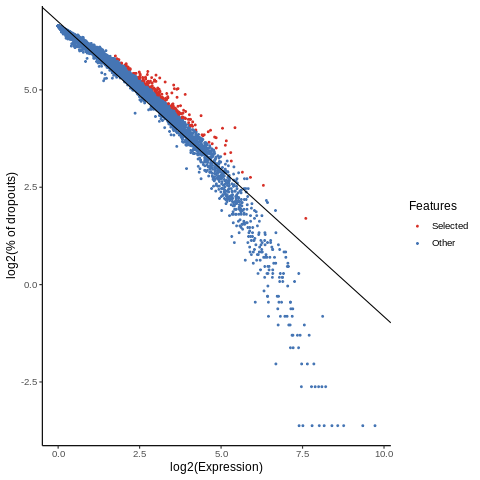

In [22]:
%%R

rowData(bian)$feature_symbol <- rownames(bian)
logcounts(bian) <- as.matrix(logcounts(bian))
bian <- selectFeatures(bian, n_features = 200, suppress_plot = FALSE)
print(table(rowData(bian)$scmap_features))

### scmap-cluster

           Mac_2       MkP      ErP      GMP Monocyte Myeloblast Lymphoblast
A2M    6.3961552 0.0000000 0.000000 0.000000 2.434654   0.000000   0.0000000
AAK1   5.0784340 0.8896653 0.000000 1.377846 3.646268   4.023462   0.7502076
ABCG2  5.4177670 0.0000000 0.000000 0.000000 1.286614   0.000000   0.0000000
ADAM28 0.7413089 0.0000000 0.000000 0.000000 4.257180   0.000000   4.8852141
ADAP2  7.1489291 0.0000000 0.000000 0.000000 5.102187   1.930580   0.0000000
AGR2   8.5981185 1.3359149 1.435892 1.706307 7.156074   2.130966   4.9204157
             LMP      EMP Mast cell    Mac_4    Mac_1      ILC    Mac_3
A2M    1.3511011 0.000000  0.000000 7.541320 6.160611 0.000000 6.367744
AAK1   1.8842646 0.000000  1.212555 5.578574 4.689392 4.887452 5.371381
ABCG2  0.8231798 0.000000  0.000000 3.373865 5.583679 0.000000 5.059771
ADAM28 4.5268630 0.000000  0.000000 5.917282 0.000000 0.000000 0.000000
ADAP2  3.5046270 0.000000  0.000000 6.389392 6.806798 0.000000 7.209229
AGR2   6.7208834 1.071185  1.

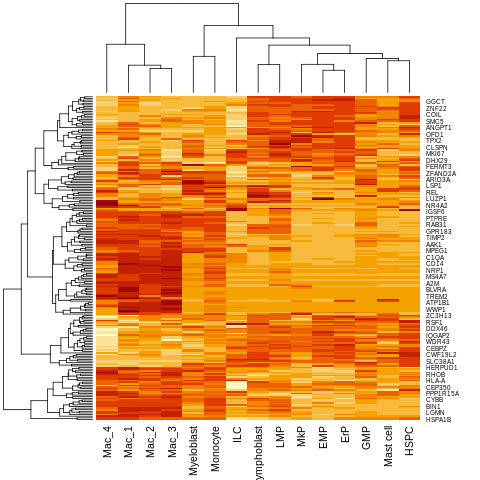

In [23]:
%%R 

bian <- indexCluster(bian, cluster_col = "paper_cluster")
print(head(metadata(bian)$scmap_cluster_index))
heatmap(as.matrix(metadata(bian)$scmap_cluster_index))

#### Projection

In [24]:
%%R 

rowData(atlas)$feature_symbol <- rownames(atlas)
counts <- assay(atlas, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(atlas) <- log2(t(t(counts)/size.factors) + 1)
logcounts(atlas) <- as.matrix(logcounts(atlas))
assayNames(atlas)

[1] "X"         "logcounts"


In [25]:
%%R -o scmapCluster_results

scmapCluster_results <- scmapCluster(
  projection = atlas, 
  index_list = list(
    bian = metadata(bian)$scmap_cluster_index
  )
)

In [26]:
%%R 

print(head(scmapCluster_results$scmap_cluster_labs))
print(head(scmapCluster_results$scmap_cluster_siml))
print(head(scmapCluster_results$combined_labs))

     bian        
[1,] "unassigned"
[2,] "Myeloblast"
[3,] "unassigned"
[4,] "Monocyte"  
[5,] "Mac_4"     
[6,] "unassigned"
          bian
[1,] 0.3537776
[2,] 0.7355914
[3,] 0.5885660
[4,] 0.7021263
[5,] 0.7857722
[6,] 0.5530670
[1] "unassigned" "Myeloblast" "unassigned" "Monocyte"   "Mac_4"     
[6] "unassigned"


In [27]:
%%R -o visualize

visualize <- plot(
  getSankey(
    colData(atlas)$clusters, 
    scmapCluster_results$scmap_cluster_labs[,'bian'],
    plot_height = 400
  )
)

In [28]:
%%R

visualize

[1] "/tmp/RtmpjYzTk2/SankeyID5ad6c3fbe81.html"


In [29]:
labels = list(scmapCluster_results[0])

In [30]:
atlas.obs['scmap_labels'] = labels
atlas.obs['scmap_labels'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


unassigned     6072
Mac_4           345
Mac_1           219
Monocyte        216
Myeloblast      185
Mac_2           155
Mac_3           121
ErP             111
HSPC             58
Mast cell        45
GMP              26
Lymphoblast      13
MkP               8
EMP               5
LMP               2
Name: scmap_labels, dtype: int64

In [31]:
similarities = scmapCluster_results[1]
similarities = [val for sublist in similarities for val in sublist]
#similarities

In [32]:
atlas.obs['scmap_similarities'] = similarities

#### Save scmap results 

In [33]:
atlas.obs[['scmap_labels', 'scmap_similarities']].to_csv(path_to_atlas + 'scmap_from_Bian.csv')